In [1]:
import pandas as pd
import numpy as np

In [2]:
dct = {
    "Component" : ["C1","C2","C3","C4","C5","C6","C7+"],
    "yi_1" : [0.78,0.065,0.052,0.039,0.026,0.013,0.025],
    "yi_2" : [0.58,0.045,0.042,0.029,0.066,0.063,0.175],
    "Pc" : [666.4,706.5,616,527.9,488.6,453,286],
    "Tc" : [343.33,549.92,666.06,765.62,845.8,923,1188],
    "wi" : [0.0104,0.0979,0.1522,0.1852,0.228,0.25,0.5733],
    "MW" : [16,30,44,58,72,86,260]
}
df = pd.DataFrame(dct)

In [3]:
df.to_excel("component psi.xlsx",index=False)

In [4]:
T = 131.3+460 #(F)+460, Rankine
R = 10.731557089016 #psi.ft3/(lbmol.R)

In [56]:
T

591.3

In [5]:
#Kappa Calculation
wi = np.asarray(df['wi'],dtype=float)
kp = 0.37464+1.54226*wi-0.26992*wi**2

In [6]:
print(kp)

[0.39065031 0.52304023 0.60311932 0.65100856 0.71224376 0.743335
 1.17010227]


In [7]:
pc = np.asarray(df['Pc'],dtype=float)
tc = np.asarray(df['Tc'],dtype=float)
tr = T/tc

alph = (1+kp*(1-np.sqrt(tr)))**2
ai = 0.45724*R**2*tc**2/pc
bi = 0.0778*R*tc/pc

In [8]:
print(alph)
print(ai)
print(bi)

[0.77085288 0.96172974 1.07092456 1.16400941 1.2470646  1.31876545
 1.80794267]
[  9314.47143533  22540.13744558  37924.1355756   58471.54564846
  77099.50602575  99031.85102226 259858.27114082]
[0.43014918 0.64987478 0.90276555 1.21088792 1.44529518 1.70116264
 3.46810905]


In [9]:
l = len(df)
y1 = np.asarray(df['yi_1'],dtype=float)
y2 = np.asarray(df['yi_2'],dtype=float)

aam_1 = 0
aam_2 = 0
for i in range(l):
    for j in range(l):
        aam_1 = aam_1 + y1[i]*y1[j]*np.sqrt(ai[i]*ai[j]*alph[i]*alph[j])
        aam_2 = aam_2 + y2[i]*y2[j]*np.sqrt(ai[i]*ai[j]*alph[i]*alph[j])
bm_1 = sum(y1*bi)
bm_2 = sum(y2*bi)
print("aam1 = %f"%aam_1,"bm1 = %f"%bm_1)
print("aam2 = %f"%aam_2,"bm2 = %f"%bm_2)

aam1 = 15929.842148 bm1 = 0.618322
aam2 = 55217.431989 bm2 = 1.161245


In [10]:
P = np.arange(0,1510,10,dtype="float")

In [11]:
A1 = aam_1*P/(R**2*T**2)
A2 = aam_2*P/(R**2*T**2)
B1 = bm_1*P/(R*T)
B2 = bm_2*P/(R*T)

In [12]:
# t# as polynomial term (t1)x^3+(t2)x^2+(t3)x+(t4)
t11 = 1
t21 = -(1-B1)
t31 = A1-3*B1**2-2*B1
t41 = -(A1*B1-B1**2-B1**3)

t12 = 1
t22 = -(1-B2)
t32 = A2-3*B2**2-2*B2
t42 = -(A2*B2-B2**2-B2**3)

In [13]:
rt1 = []
rt2 = []
for i in range(len(P)):
    p1 = np.poly1d([t11,t21[i],t31[i],t41[i]])
    p2 = np.poly1d([t12,t22[i],t32[i],t42[i]])
    rt1 = rt1 + [p1.roots]
    rt2 = rt2 + [p2.roots]

In [14]:
#Real and Imaginer Number Identification
cond1 = []
cond2 = []
z1 = []
z2 = []
for j in range(len(P)):
    count_real1 = sum(rt1[j].imag == 0)
    count_real2 = sum(rt2[j].imag == 0)
    if count_real1 == 1: #one phase
        cond1 += [1]
        z1 += [rt1[j][rt1[j].imag==0].real[0]]
    elif count_real1 == 3: #two phase, zfactor vapour = max(z)
        cond1 += [2]
        z1 += [max(rt1[j].real)]
    if count_real2 == 1: #one phase
        cond2 += [1]
        z2 += [rt2[j][rt2[j].imag==0].real[0]]
    elif count_real2 == 3: #two phase, zfactor vapour = max(z)
        cond2 += [2]
        z2 += [max(rt2[j].real)]

In [15]:
MW = np.asarray(df["MW"],dtype=int)
MWa1 = sum(y1*MW)
MWa2 = sum(y2*MW)
GamG1 = MWa1/28.97
GamG2 = MWa2/28.97

In [16]:
GamG1,GamG2

(0.9827407663099759, 2.4104245771487744)

In [17]:
Ppc = [sum(y1*pc),sum(y2*pc)]
Tpc = [sum(y1*tc),sum(y2*tc)]
Ppc,Tpc

([644.0772000000002, 570.3222], [431.7262999999999, 595.9271])

In [18]:
#Density Gas Calculation
rho_g1 = P/z1*2.7*GamG1/T
rho_g2 = P/z2*2.7*GamG2/T
#lbm/ft3

In [19]:
#Viscosity Gas Calculation
Am1 = (9.379*0.01607*MWa1)*T**1.5/(209.2+19.26*MWa1+T)
Bm1 = 3.448 + 986.4/T + 0.01009*MWa1
Cm1 = 2.447 - 0.2224*Bm1

Am2 = (9.379*0.01607*MWa2)*T**1.5/(209.2+19.26*MWa2+T)
Bm2 = 3.448 + 986.4/T + 0.01009*MWa2
Cm2 = 2.447 - 0.2224*Bm2

mug1 = Am1*np.exp(Bm1*(rho_g1/62.428)**Cm1)*1e-4
mug2 = Am2*np.exp(Bm2*(rho_g2/62.428)**Cm2)*1e-4
#cP

In [20]:
#Calculation
#Component 1
D1 = 2*P/(z1*mug1)
E1 = (D1[:-1]+D1[1:])/2
F1 = P[1:]-P[:-1]
G1 = E1*F1
H1 = np.insert(np.cumsum(G1),0,0,axis=0)

#Component 2
D2 = 2*P/(z2*mug2)
E2 = (D2[:-1]+D2[1:])/2
F2 = P[1:]-P[:-1]
G2 = E2*F2
H2 = np.insert(np.cumsum(G2),0,0,axis=0)

In [21]:
z1_ext = []
z1_ext.extend(z1)
z1_ext[0] = float("NaN")

z2_ext = []
z2_ext.extend(z2)
z2_ext[0] = float("NaN")

mug1_ext = []
mug1_ext.extend(mug1)
mug1_ext[0] = float("NaN")

mug2_ext = []
mug2_ext.extend(mug2)
mug2_ext[0] = float("NaN")

E1_ext = []
E1_ext.extend(E1)
F1_ext = []
F1_ext.extend(F1)
G1_ext = []
G1_ext.extend(G1)

E2_ext = []
E2_ext.extend(E2)
F2_ext = []
F2_ext.extend(F2)
G2_ext = []
G2_ext.extend(G2)

In [22]:
dct1 = {
    "P" : P[0:150:15],
    "zFactor" : z1_ext[0:150:15],
    "gas_visc" : mug1_ext[0:150:15],
    "D" : D1[0:150:15],
    "E" : np.insert(E1_ext,0,float("NaN"),axis=0)[0:150:15],
    "F" : np.insert(F1_ext,0,float("NaN"),axis=0)[0:150:15],
    "G" : np.insert(G1_ext,0,float("NaN"),axis=0)[0:150:15],
    "H" : H1[0:150:15]
}
dct2 = {
    "P" : P[0:150:15],
    "zFactor" : z2_ext[0:150:15],
    "gas_visc" : mug2_ext[0:150:15],
    "D" : D2[0:150:15],
    "E" : np.insert(E2_ext,0,float("NaN"),axis=0)[0:150:15],
    "F" : np.insert(F2_ext,0,float("NaN"),axis=0)[0:150:15],
    "G" : np.insert(G2_ext,0,float("NaN"),axis=0)[0:150:15],
    "H" : H2[0:150:15]
}
df_res1 = pd.DataFrame(dct1)
df_res2 = pd.DataFrame(dct2)

In [23]:
df_res1

,P,zFactor,gas_visc,D,E,F,G,H
0,0.0,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000e+00
1,150.0,0.955248,0.004668,67277.971989,64992.249333,10.0,6.499225e+05,5.008504e+06
2,300.0,0.910574,0.004814,136877.449513,134533.549624,10.0,1.345335e+06,2.029891e+07
3,450.0,0.866265,0.005005,207565.724622,205205.895449,10.0,2.052059e+06,4.612671e+07
4,600.0,0.822774,0.005248,277908.472035,275586.440799,10.0,2.755864e+06,8.255205e+07
5,750.0,0.780794,0.005552,346040.412835,343826.197438,10.0,3.438262e+06,1.293893e+08
6,900.0,0.741328,0.005928,409593.033989,407572.798719,10.0,4.075728e+06,1.861354e+08
7,1050.0,0.705693,0.006388,465838.228044,464104.558665,10.0,4.641046e+06,2.519009e+08
8,1200.0,0.675366,0.006938,512190.485553,510819.520257,10.0,5.108195e+06,3.253895e+08
9,1350.0,0.651601,0.007575,547019.094029,546042.305046,10.0,5.460423e+06,4.049778e+08


In [24]:
df_res2

,P,zFactor,gas_visc,D,E,F,G,H
0,0.0,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000e+00
1,150.0,0.792987,0.007918,47779.769876,45983.541396,10.0,459835.413964,3.440756e+06
2,300.0,0.090020,0.165220,40341.486492,40412.468083,10.0,404124.680832,1.315909e+07
3,450.0,0.132566,0.176779,38404.159595,38463.721781,10.0,384637.217815,1.906081e+07
4,600.0,0.173958,0.187668,36757.628592,36808.788901,10.0,368087.889007,2.469484e+07
5,750.0,0.214405,0.198022,35329.949142,35374.661373,10.0,353746.613730,3.009902e+07
6,900.0,0.254061,0.207933,34073.076347,34112.682145,10.0,341126.821447,3.530236e+07
7,1050.0,0.293038,0.217469,32953.242687,32988.704939,10.0,329887.049391,4.032780e+07
8,1200.0,0.331423,0.226681,31945.769447,31977.803442,10.0,319778.034423,4.519395e+07
9,1350.0,0.369287,0.235607,31032.054228,31061.206246,10.0,310612.062464,4.991622e+07


In [54]:
with pd.ExcelWriter("psi.xlsx") as writer:
    df_res1.to_excel(writer, index=False, sheet_name="Component 1")
    df_res2.to_excel(writer, index=False,sheet_name="Component")
print("Result is saved on output.xlsx, please check your directory")

Result is saved on output.xlsx, please check your directory


In [25]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

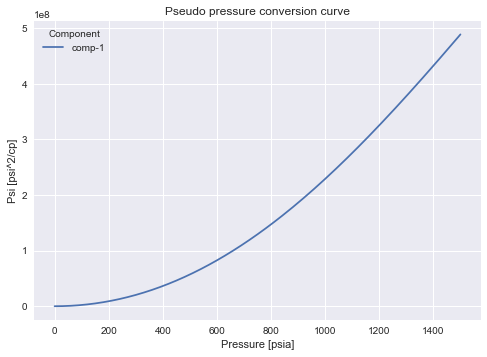

<Figure size 720x864 with 0 Axes>

In [26]:
plt.plot(P,H1,label='comp-1')
plt.title("Pseudo pressure conversion curve")
plt.xlabel('Pressure [psia]')
plt.ylabel('Psi [psi^2/cp]')
plt.legend(title='Component')
plt.figure(figsize=(10,12))
plt.show()

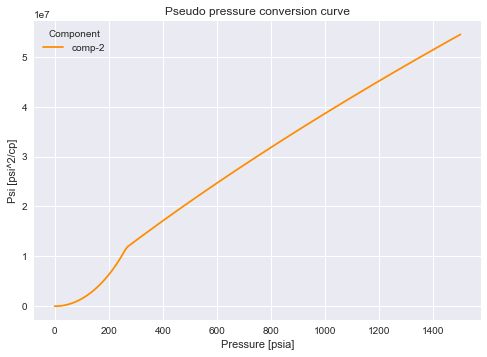

<Figure size 720x864 with 0 Axes>

In [27]:
plt.plot(P,H2,label='comp-2',color='darkorange')
plt.title("Pseudo pressure conversion curve")
plt.xlabel('Pressure [psia]')
plt.ylabel('Psi [psi^2/cp]')
plt.legend(title='Component')
plt.figure(figsize=(10,12))
plt.show()

In [50]:
V = 650 #psia
if (V == P).any() == True:
    print(str(round(H1[V==P][0]/1e7,3))+" x 1e7 [psi^2/cp]")
else:
    Po = P[P<V][-1]
    Pl = P[P>V][0]
    Ho = H1[P==Po][0]
    Hl = H1[P==Pl][0]
    m = (Hl-Ho)/(Pl-Po)
    Hres = m*(V-Po)+Ho
    print(str(round(Hres/1e7,3))+" x 1e7 [psi^2/cp]")

9.703 x 1e7 [psi^2/cp]


In [49]:
V = 650 #psia
if (V == P).any() == True:
    print(str(round(H2[V==P][0]/1e7,3))+" x 1e7 [psi^2/cp]")
else:
    Po = P[P<V][-1]
    Pl = P[P>V][0]
    Ho = H2[P==Po][0]
    Hl = H2[P==Pl][0]
    m = (Hl-Ho)/(Pl-Po)
    Hres = m*(V-Po)+Ho
    print(str(round(Hres/1e7,3))+" x 1e7 [psi^2/cp]")

2.652 x 1e7 [psi^2/cp]
